In [1]:
from datetime import datetime
import os
import re
import warnings
import sys
import scipy.constants as sp
import pandas as pd


# third party
from obspy.core.trace import Trace
from obspy.core.stream import Stream
from obspy.core.trace import Stats
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

import processing
import arias_intensity
import CAV

from amptools.io.knet.core import read_knet
from amptools.stream import group_channels
from obspy import UTCDateTime

import glob

from libcomcat.search import get_event_by_id
from obspy.geodetics import gps2dist_azimuth, kilometers2degrees
from obspy.taup import TauPyModel

from obspy import read
from matplotlib.dates import date2num
from matplotlib.pyplot import close
import warnings
warnings.filterwarnings('ignore')

In [2]:
stream = Stream()
trace = Trace()

# read knet
from obspy import read 

os.chdir("/Users/tnye/PROJECTS/Duration/data/usp000a1b0/ground_motion/knt")
types = ('*.EW', '*.NS', '*.UD')
files_grabbed = []
for files in types:
    files_grabbed.extend(glob.glob(files))

data = []
for i in range(len(files_grabbed)):
    data.append(read(files_grabbed[i]))

stations = group_channels(data)

for sta in stations:
    sta.detrend('demean')

In [3]:
station_stats = []
for i in range(len(stations)):
    station = stations[i]
    trace = station[0]
    name = trace.stats['station']
    source_lat = trace.stats['knet']['stla']
    source_lon = trace.stats['knet']['stlo']
    elev = trace.stats['knet']['evlo']
    station_stats.append([name, source_lat, source_lon, elev])

In [4]:
# earthquake data
event_id = 'usp000a1b0'
detail = get_event_by_id(event_id)
date = UTCDateTime(detail.time)
mag = detail.magnitude
lat = detail.latitude
lon = detail.longitude
source_coords = [lat, lon]
depth = detail.depth
print(date)

2000-10-06T04:30:19.150000Z


In [5]:
# append station stats 
model = TauPyModel(model="iasp91")
for sta in stations:
    for i in range(len(sta)):
        trace = sta[i]
        
        # Compute distance
        dist_az_baz = gps2dist_azimuth(
            trace.stats['knet']['stla'],
            trace.stats['knet']['stlo'],
            source_coords[0], source_coords[1])
        distance_meters = dist_az_baz[0]
        distance_km = distance_meters/1000.0
        dd = kilometers2degrees(distance_km)
        #trace.stats.distance = distance_meters
        trace.stats.rdist = distance_km
        
        # Estimated travel time for p wave
        p = model.get_travel_times(depth, dd, phase_list=['p', 'P'])
        trace.stats.P_arriv = p[0].time
        
        # Apply calibration factor to get from gals to m/s^2
        trace.data = trace.data * trace.stats.calib * 100
        # Set calibration to 1 to avoid double calibration when plotting
        trace.stats.calib = 1

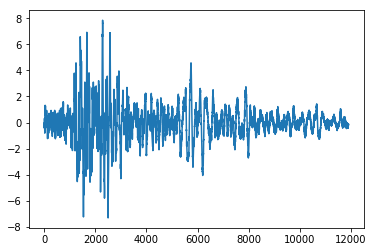

In [6]:
plt.plot(stations[0][0].data)
plt.show()

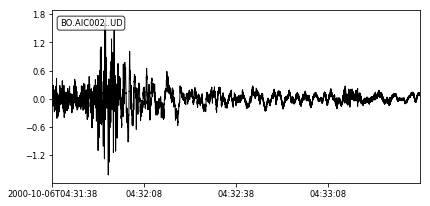

In [7]:
fig = plt.figure()
    
stations[1][1].plot(fig=fig, show=False)
p_onset = date + stations[1][1].stats['P_arriv']
    
ax = fig.axes[0]
ax.axvline(date2num(p_onset.datetime), lw=2)

In [8]:
stz = Stream()
for sta in stations:
    newtrace = sta.select(channel='UD')
    stz += newtrace

In [10]:
#stz.plot(type='section', vred=3000., ev_coord=source_coords)

In [14]:
stz = Stream()
for sta in stations:
    newtrace = sta.select(channel='UD')
    stz += newtrace
    
#dist = [s.stats['distance']/1000.0 for s in stz]
ptime = [s.stats['P_arriv'] for s in stz]
ptime2 = [15]*len(ptime)

#fig = plt.figure()
#stz.plot(fig=fig, type='section', vred=None, ev_coord=source_coords)
#ax = fig.axes[0]
#ax.plot(dist, ptime, "b.")
#ax.set_xlabel("Distance (km)")
#ax.set_xlim([0, 100])
#ax.set_ylim([0, 40])


In [15]:
stz.sort(['rdist'])
dists = [tr.stats.rdist for tr in stz]
#print(dists)

In [16]:
temp = stz.select(station='SMN018')
print(temp[0].stats)

         network: BO
         station: SMN018
        location: 
         channel: UD
       starttime: 2000-10-06T04:30:24.000000Z
         endtime: 2000-10-06T04:32:31.990000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 12800
           calib: 1
         P_arriv: 14.267188995562211
         _format: KNET
            knet: AttribDict({'last correction': UTCDateTime(2000, 10, 6, 4, 0), 'accmax': 31.171, 'stel': 5.0, 'mag': 7.3, 'evlo': 133.345, 'evdp': 11.0, 'evla': 35.278, 'stlo': 133.2331, 'stla': 36.1925, 'evot': UTCDateTime(2000, 10, 6, 4, 30), 'duration': 128.0})
      processing: ["ObsPy 1.1.0: detrend(options={}::type='demean')"]
           rdist: 82.20808734397828


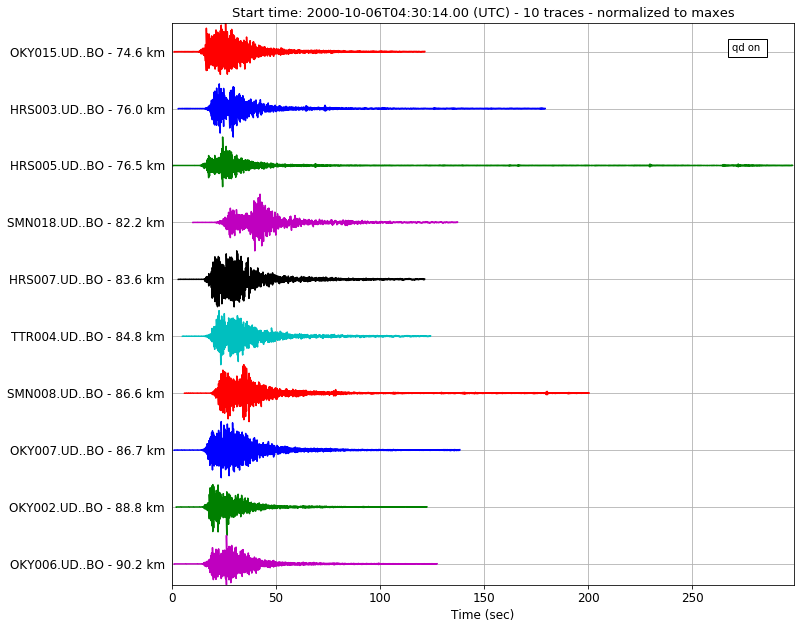

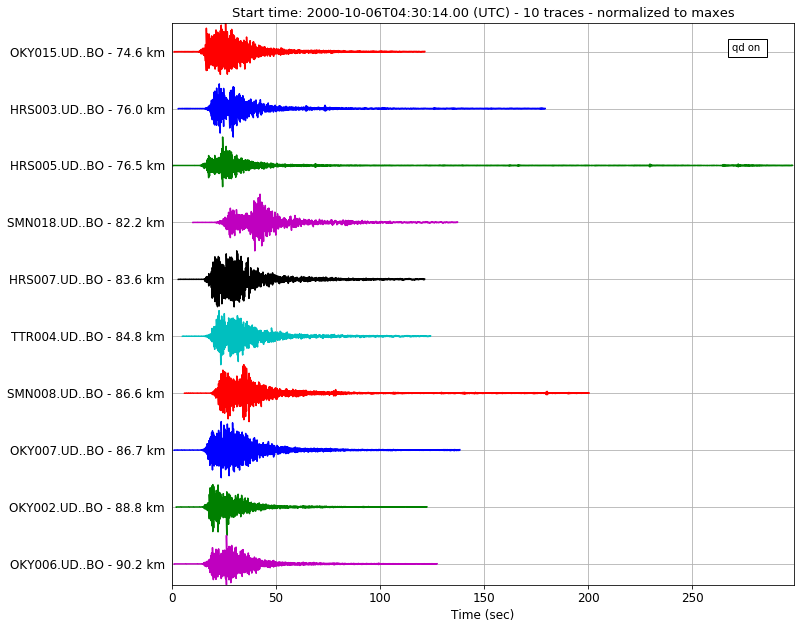

In [17]:
from reviewData import reviewData
reviewData.recsec(stz[20:30])

In [ ]:
p_onset = date + sorted_stz[19].stats['P_arriv']
print(p_onset)

In [ ]:
sorted_stz[18].stats

In [ ]:
close('all')